# COGS 181 Final Project LBP on CNN

### Yushan Wang A14459085
### Jiemin Tang A

### Import package

In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import os
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd 
from random import shuffle
from random import randint
from sklearn.svm import LinearSVC
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from sklearn.decomposition import NMF

# It should print "Using TensorFlow backend"

Using TensorFlow backend.


### Helper function

In [2]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [3]:
def smallest(num1,num2,num3):
    if(num1<num2 and num1<num3):
        return num1
    elif (num2<num3):
        return num2
    else:
        return num3

In [4]:
def eucldist(x,y): 
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

In [5]:
def DMS(p,q):
    if len(p) == 8 & len(q) == 8:
        p9 = p.copy()
        q9 = q.copy()
        
        p9.append(0)
        q9.append(0)
        revp = p9[::-1]
        revq = q9[::-1]
        
        serp = pd.Series(p9)
        serq = pd.Series(q9)
        serrevp = pd.Series(revp) 
        serrevq = pd.Series(revq) 
        cdfp = serp.cumsum()
        cdfq = serq.cumsum()
        cdfrevp = serrevp.cumsum() 
        cdfrevq = serrevq.cumsum()
        
        a1 = eucldist(cdfp.tolist(), cdfq.tolist())
        a2 = eucldist(cdfrevp.tolist(), cdfq.tolist())
        a3 = eucldist(cdfp.tolist(), cdfrevq.tolist())
        x = smallest(a1,a2,a3) 
    return x

In [6]:
'''
This is the file for the local Binary Pattern
'''

from skimage import feature
import numpy as np
import random 
import os

class LocalBinaryPatterns:
    # init_function
    def __init__(self, numPoints, radius, center):
        # store the center of the LBP
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
        self.center = center

    # do the LBP transformation and transform to histogram
    def histogram(self, image, eps=1e-6):
        lbp = feature.local_binary_pattern(image, self.numPoints,self.radius, method="uniform")
        hist, _ = np.histogram(lbp.ravel(),	bins=np.arange(0, self.numPoints + 3),range=(0, self.numPoints + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist

### Initialize path directories for dataset

In [7]:
# paths for thw two dataset folders
mask = r'dataset/mask'
no_mask = r'dataset/no_mask'

### Load and Store images

In [8]:
# store images from the dataset
images = []
labels = []
for file in list(os.listdir(mask)):
    images.append(cv2.imread(mask+'/'+file))
    labels.append(1)
    
for file in list(os.listdir(no_mask)):
    images.append(cv2.imread(no_mask+'/'+file)) 
    labels.append(0)
    
images = np.array(images)

### Initialize the LBP

In [9]:
lbp = LocalBinaryPatterns(24, 8, 0)

### shuffle and split data

In [10]:
data_size = len(labels)
index = list(range(data_size))
shuffle(index)
index = np.array(index)
images =   images[index]
labels =   np.array(labels)[index]

image_train =  images[:int(0.8*data_size)]
y_train =  labels[:int(0.8*data_size)] 

image_test =  images[int(0.8*data_size):]
y_test =   labels[int(0.8*data_size):]

### Preview data
#### Show random image with corresponding label

Without Mask


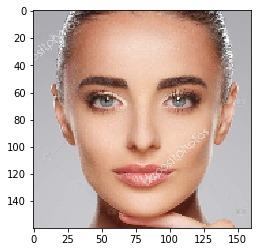

In [11]:
rand_int = randint(0, len(image_test))
plt.imshow(image_test[rand_int][:,:,::-1])
if y_test[rand_int] == 1:
    print('With Mask')
else:
    print('Without Mask')

### Fit the MDS model

In [12]:
import itertools
n = 8
lst = list(map(list, itertools.product([0, 1], repeat=n)))
print(len(lst))

256


In [13]:
#print(len(lst[0]))
delta_matrix = np.zeros((len(lst), len(lst))) 
for i in range(0,len(lst)):
    for j in range(0,len(lst)):
        if i != j:
            delta_matrix[i,j] = DMS(lst[i],lst[j]) 
        else:
            delta_matrix[i,j] = 0

In [14]:
embedding = MDS(n_components=3,dissimilarity='precomputed')
embedding.fit(delta_matrix)


MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
    n_components=3, n_init=4, n_jobs=None, random_state=None, verbose=0)

In [15]:
NMF_model = NMF(n_components=3, init='random', random_state=0)

### Transform image to LBP code

#### Training_image

In [16]:
data= []
num =0
for image in image_train:
    num = num + 1
    bin_img = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_image = feature.local_binary_pattern(gray, 24, 8, method='uniform')
    lbp_image = lbp_image.tolist()
    for row in lbp_image:
        bin_row = []
        for input in row:
            bin_pt = [int(x) for x in '{:08b}'.format(int(input))]
            bin_row.append(bin_pt)
        bin_row = np.reshape(np.array(bin_row),(160,8)) 
        bin_row = NMF_model.fit_transform(bin_row)
        bin_row = np.reshape(bin_row,(160,3))
        bin_img.append(bin_row)
    bin_img = np.reshape(bin_img,(160,160,3))
    data.append(bin_img)
    if num%100 == 0:
        print(num)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


In [17]:
num =0
for image in image_test:
    num = num+1
    bin_img = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_image = feature.local_binary_pattern(gray, 24, 8, method='uniform')
    lbp_image = lbp_image.tolist()
    for row in lbp_image:
        bin_row = []
        for input in row:
            bin_pt = [int(x) for x in '{:08b}'.format(int(input))]
            bin_row.append(bin_pt)
        bin_row = np.reshape(np.array(bin_row),(160,8)) 
        bin_row = NMF_model.fit_transform(bin_row)
        bin_row = np.reshape(bin_row,(160,3))
        bin_img.append(bin_row)
    bin_img = np.reshape(bin_img,(160,160,3))
    if num%100 == 0:
        print(num)
    data.append(bin_img)

100
200
300
400
500


### shuffle and split data

In [29]:
# store labels (mask = 1,0 and  no mask = 0,1)
n_mask = len(list(os.listdir(mask)))
n_no_mask = len(list(os.listdir(no_mask)))
labels = np.zeros(( n_mask  + n_no_mask, 2  ))
labels[:n_mask,0] = 1
labels[n_mask:,1] = 1
print('y shape',labels.shape)   #(1376, 2)
print('x shape',images.shape)   #(1376, 160, 160, 3)

y shape (2767, 2)
x shape (2767, 160, 160, 3)


In [30]:
data = np.array(data)
data_size = len(labels)
index = list(range(data_size))
shuffle(index)
index = np.array(index)
images =   images[index]
labels =   np.array(labels)[index]

image_train =  images[:int(0.8*data_size)]
y_train =  labels[:int(0.8*data_size)] 
x_train = data[:int(0.8*data_size)]

image_test =  images[int(0.8*data_size):]
y_test =   labels[int(0.8*data_size):]
x_test = data[int(0.8*data_size):]

### Initialize parameters

In [31]:
img_rows, img_cols = images.shape[1], images.shape[2]
input_shape = (images.shape[1], images.shape[2], images.shape[3])
batch_size = 1
num_classes = 2

In [36]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(num_classes, activation='sigmoid'))

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 18, 18, 64)       

In [37]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 2213 samples, validate on 554 samples
Epoch 1/10
2213/2213 [==============================] - 139s 63ms/step - loss: 0.6930 - accuracy: 0.5269 - val_loss: 0.6913 - val_accuracy: 0.5307
Epoch 2/10
2213/2213 [==============================] - 138s 62ms/step - loss: 0.6916 - accuracy: 0.5350 - val_loss: 0.6922 - val_accuracy: 0.5307
Epoch 3/10
2213/2213 [==============================] - 145s 65ms/step - loss: 0.6918 - accuracy: 0.5386 - val_loss: 0.6913 - val_accuracy: 0.5307
Epoch 4/10
2213/2213 [==============================] - 139s 63ms/step - loss: 0.6914 - accuracy: 0.5386 - val_loss: 0.6913 - val_accuracy: 0.5307
Epoch 5/10
2213/2213 [==============================] - 140s 63ms/step - loss: 0.6911 - accuracy: 0.5386 - val_loss: 0.6913 - val_accuracy: 0.5307
Epoch 6/10
2213/2213 [==============================] - 142s 64ms/step - loss: 0.6909 - accuracy: 0.5386 - val_loss: 0.6913 - val_accuracy: 0.5307
Epoch 7/10
2213/2213 [==============================] - 105s 47ms/step 